In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

archive/Submission.csv
archive/fer2013/fer2013/fer2013.csv
archive/fer2013/fer2013/fer2013.bib
archive/fer2013/fer2013/README


In [2]:
import math
import numpy as np
import pandas as pd

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

from livelossplot.tf_keras import PlotLossesCallback

import tensorflow.keras.utils as np_utils


2025-05-02 09:39:27.740094: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 09:39:27.750382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746196767.762851   62339 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746196767.766675   62339 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746196767.776096   62339 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Analisis de datos

In [3]:
df = pd.read_csv('archive/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {
    0:'anger', 1:'disgust', 2:'fear', 
    3:'happiness', 4:'sadness', 5:'surprise', 
    6:'neutral'
}

In [6]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

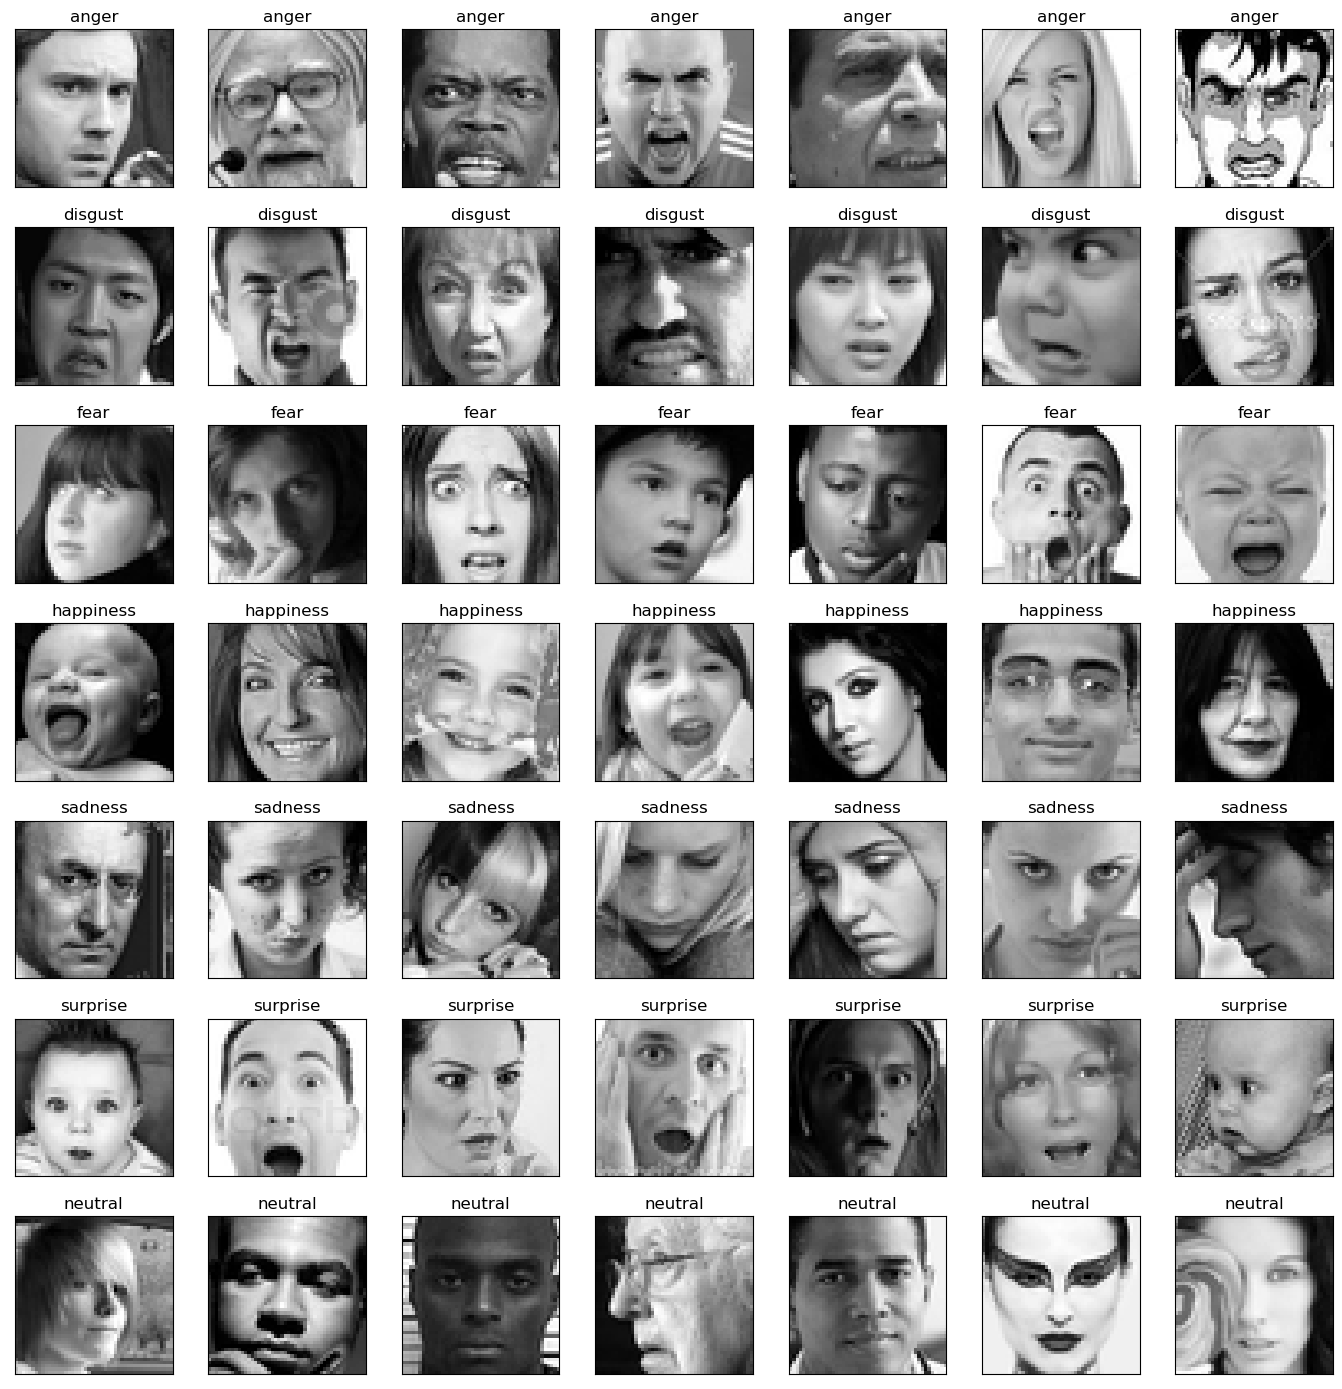

In [7]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [8]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)
img_array.shape

(35887, 48, 48)

In [9]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
img_features.shape

(35887, 48, 48, 3)

In [10]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [11]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

# Configuracion del modelo

In [12]:
CONFIGURATION = {
    "IM_SIZE": 48,
    "FINAL_CONV_LAYER": -2,
    "NUM_CLASSES": 7,
    "LEARNING_RATE": 0.0001,
    "BATCH_SIZE": 32, 
    "N_EPOCHS": 25,
}

# Preprocesamiento

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(
    img_features, 
    img_labels, 
    shuffle = True, 
    stratify = img_labels, 
    test_size = 0.1, 
    random_state = 42
)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [14]:
del df
del img_features
del img_labels

In [15]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,)

train_datagen.fit(X_train)

# Transfer Learning - VGG19

In [17]:
vgg = tf.keras.applications.VGG19(
    weights = 'imagenet',
    include_top = False,
    input_shape = (
        CONFIGURATION['IM_SIZE'],
        CONFIGURATION['IM_SIZE'], 
        3
    ))

vgg.summary()

I0000 00:00:1746196795.743459   62339 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1729 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
def build_model(bottom_model):
    model = bottom_model.layers[CONFIGURATION["FINAL_CONV_LAYER"]].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(CONFIGURATION["NUM_CLASSES"],
                  activation = 'softmax', 
                  name = 'out_layer')(model)
    
    return model

In [19]:
head = build_model(vgg)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,027,975 (76.40 MB)

 Trainable params: 20,027,975 (76.40 MB)

 Non-trainable params: 0 (0.00 B)

None


# Callbacks para entrenamiento

In [20]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.00005, 
    patience = 11,
    verbose = 1, 
    restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    factor = 0.5, 
    patience = 7,
    min_lr = 1e-7,
    verbose = 1,)

callbacks = [PlotLossesCallback(), early_stopping,lr_scheduler,]

# Optimizer, Loss y Metrics

In [21]:
optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE'],
               beta_1 = 0.9, beta_2 = 0.999)

metrics = [
    CategoricalAccuracy(name='accuracy'),
    TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = metrics)

# Entrenamiento

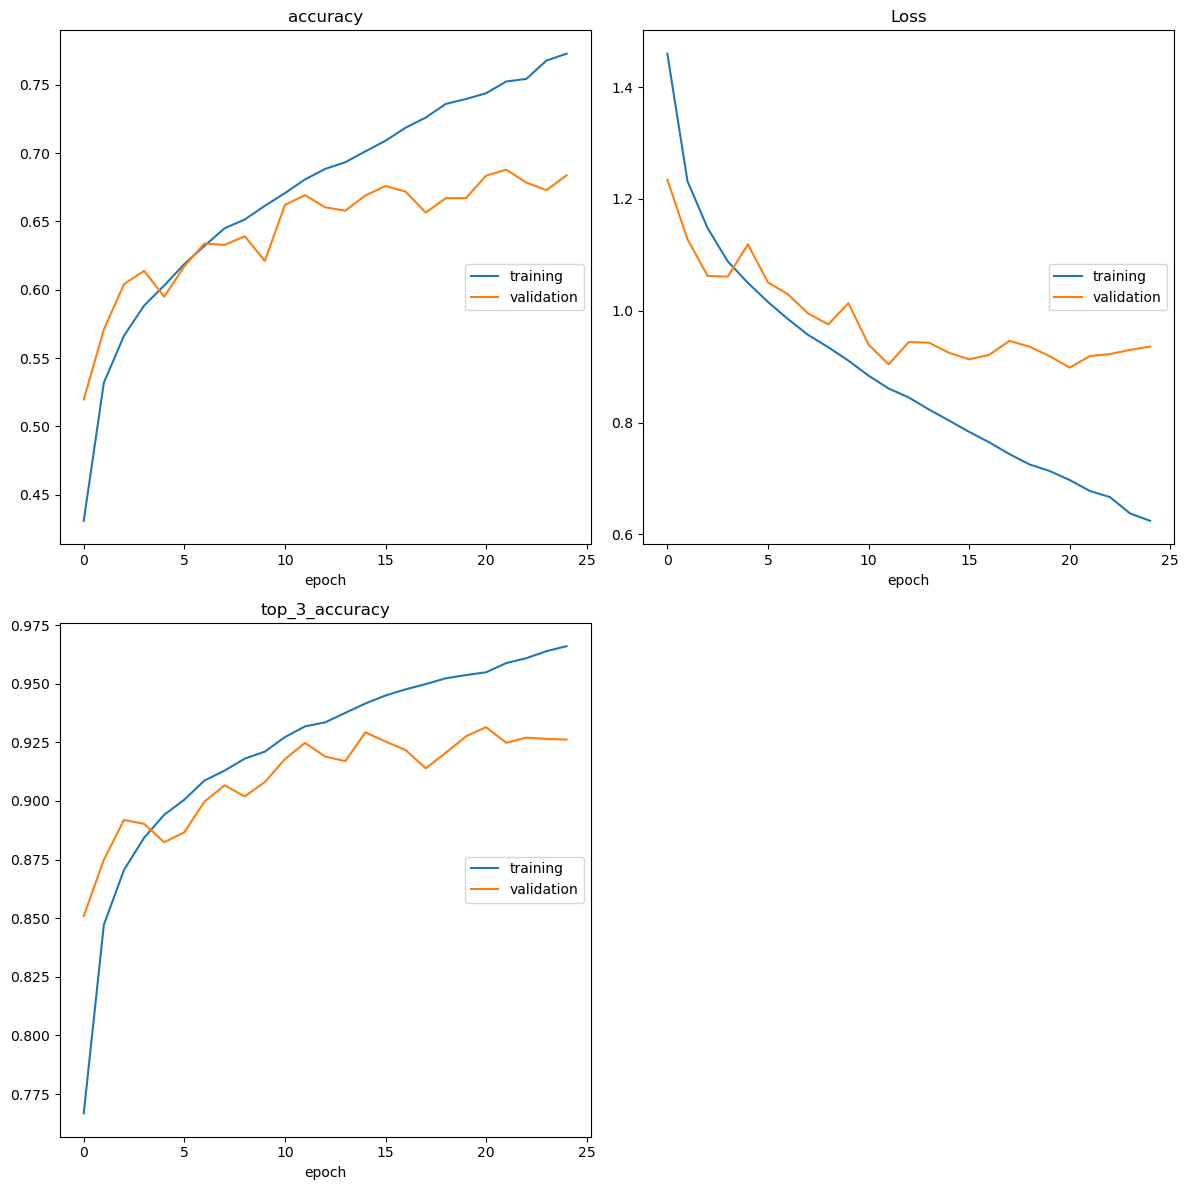

accuracy
	training         	 (min:    0.431, max:    0.773, cur:    0.773)
	validation       	 (min:    0.520, max:    0.688, cur:    0.684)
Loss
	training         	 (min:    0.624, max:    1.460, cur:    0.624)
	validation       	 (min:    0.898, max:    1.234, cur:    0.936)
top_3_accuracy
	training         	 (min:    0.767, max:    0.966, cur:    0.966)
	validation       	 (min:    0.851, max:    0.931, cur:    0.926)
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 109s 108ms/step - accuracy: 0.7764 - loss: 0.6126 - top_3_accuracy: 0.9672 - val_accuracy: 0.6838 - val_loss: 0.9358 - val_top_3_accuracy: 0.9262 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 22.


In [22]:
steps_per_epoch = math.ceil(len(X_train) / CONFIGURATION['BATCH_SIZE'])

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size = CONFIGURATION['BATCH_SIZE']),
    validation_data = (X_valid, y_valid),
    steps_per_epoch = steps_per_epoch,
    epochs = CONFIGURATION['N_EPOCHS'],
    callbacks = callbacks)

In [23]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

# Resultados

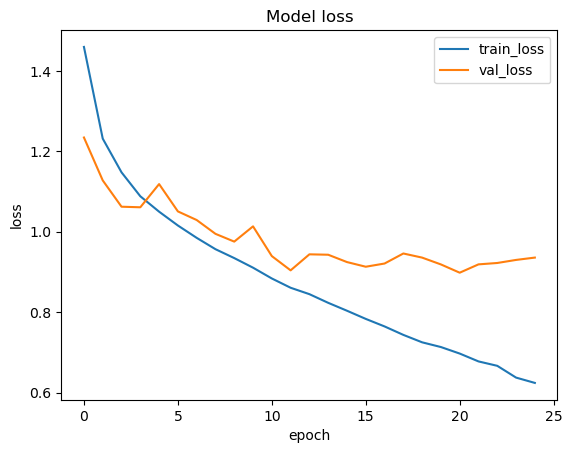

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

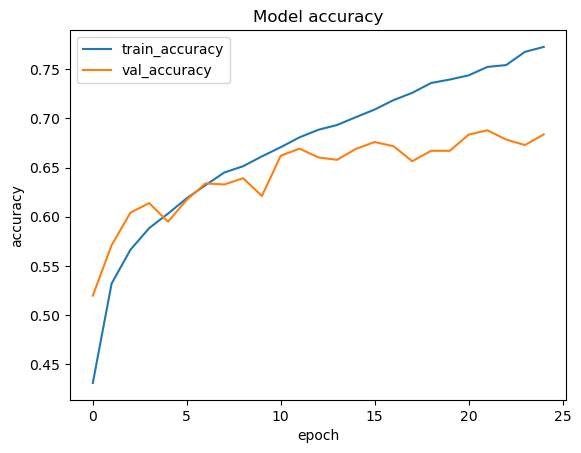

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation

In [ ]:
# val_loss, val_accuracy, _ = model.evaluate(X_valid, verbose = 0)
# print(f"Validation loss: {val_loss:.4f}")
# print(f"Validation accuracy: {val_accuracy:.4f}")

ValueError: None values not supported.

# Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
total wrong validation predictions: 1120


              precision    recall  f1-score   support

           0       0.59      0.63      0.61       495
           1       0.48      0.56      0.52        55
           2       0.59      0.44      0.50       512
           3       0.89      0.87      0.88       899
           4       0.60      0.54      0.57       608
           5       0.78      0.81      0.80       400
           6       0.60      0.75      0.67       620

    accuracy                           0.69      3589
   macro avg       0.65      0.66      0.65      3589
weighted avg       0.69      0.69      0.68      3589



<Figure size 640x480 with 0 Axes>

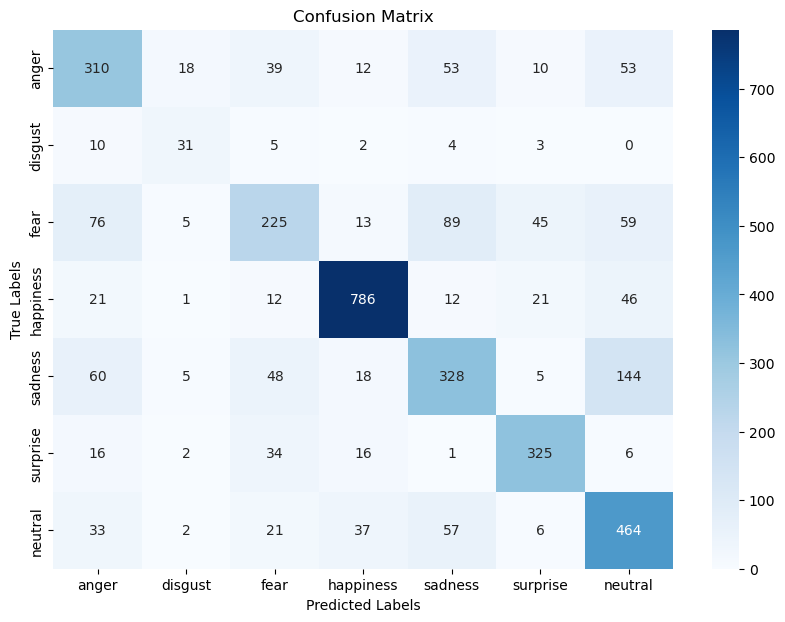

In [28]:
y_pred = np.argmax(model.predict(X_valid), axis=1)
y_true = np.argmax(y_valid, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.savefig("confusion_matrix_dcnn.png")
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != y_pred)}\n\n')
print(classification_report(y_true, y_pred))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(emotion_label_to_text.values()), 
            yticklabels=list(emotion_label_to_text.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()